In [29]:
import os

In [30]:
os.makedirs('bla/bla/bla', exist_ok=True)

In [2]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import itertools


# 19-09-2020
# param_ranges = dict(
#     accumulate_batches=[1,8,16],
#     weight_decay=[0.01, 0.001, 0.0001],
#     loss_function = [
#         'cross_entropy',
#         'soft_dice',
#         ('focal_loss', ('gamma', 1)),
#         ('focal_loss', ('gamma', 2)),
#         ('focal_loss', ('gamma', 5)),       
#         ('weighted_cross_entropy', ('class_weights', [0.52,0.85,1.09,1.28,1.26])),
#         ('weighted_cross_entropy', ('class_weights', [0.25,0.67,1.10,1.51,1.48])),
#         ('weighted_cross_entropy', ('class_weights', [0.05,0.36,0.98,1.84,1.77]))
#     ]
# )

# 20-10-2020
# param_ranges = dict(
#     accumulate_batches=[1,8,16],
#     # weight_decay=[0.01, 0.001, 0.0001],
#     loss_function = [
#         'cross_entropy',
#         'soft_dice',
#         ('focal_loss', ('gamma', 1)),
#         ('focal_loss', ('gamma', 2)),
#         ('focal_loss', ('gamma', 5)),       
#         ('weighted_cross_entropy', ('class_weights', [0.52,0.85,1.09,1.28,1.26])),
#         ('weighted_cross_entropy', ('class_weights', [0.25,0.67,1.10,1.51,1.48])),
#         ('weighted_cross_entropy', ('class_weights', [0.05,0.36,0.98,1.84,1.77]))
#     ],
#     lr = [0.01, 0.001]
# )

# 12-11-2020 (augmentation)
# param_ranges = dict(
#     augmentation_brightness=[0,1],
#     augmentation_contrast=[0,1],
#     augmentation_rotate3d=[0,1,2,3]
# )

# 19-11-2020 (augmentation)
param_ranges = dict(
    augmentation_brightness=[1],
    augmentation_contrast=[1],
    augmentation_rotate3d=[1,2,3],
    nepochs=[150]
)

experiments = []
for i, res in enumerate(itertools.product(*param_ranges.values())):
    param_dict = {}
    for k, v in zip(param_ranges.keys(),res):
        if isinstance(v, tuple):
            param_dict[k] = v[0]
            other_param_name, other_param_value = v[1]
            param_dict[other_param_name] = other_param_value
        else:
            param_dict[k] = v
    param_dict['experiment'] = i
    experiments.append(param_dict)

exp_params_df = pd.DataFrame(experiments)
exp_params_df.head()

,augmentation_brightness,augmentation_contrast,augmentation_rotate3d,nepochs,experiment
0,1,1,1,150,0
1,1,1,2,150,1
2,1,1,3,150,2


In [4]:
# runs_path = Path('/export/scratch3/bvdp/segmentation/OAR_segmentation/experiments/unet/runs')
# runs_path = Path('/export/scratch3/bvdp/segmentation/OAR_segmentation/experiments/unet/runs_augmentation/')
runs_path = Path('/export/scratch3/bvdp/segmentation/OAR_segmentation/experiments/unet/runs_augmentation_v2/')
# runs_path = Path('/export/scratch3/bvdp/segmentation/OAR_segmentation/experiments/unet/runs_19-09-2020/')

In [5]:
result_files = runs_path.glob('**/*epoch_results.csv')

In [6]:
all_dfs = []
for result_file in result_files:
    df = pd.read_csv(result_file)
#     all_dfs.append(df.assign(results_path=result_file.relative_to(result_file)))
    all_dfs.append(df.assign(results_path=result_file))

In [7]:
df = pd.concat(all_dfs)
df = df.assign(
    experiment=df.results_path.map(lambda x: x.relative_to(runs_path).parts[0].split('_')[1]).astype(int)
).merge(exp_params_df, on='experiment')
df.head()

,dice_background,dice_bladder,dice_bowel_bag,dice_hip,dice_rectum,epoch,mean_dice,precision_background,precision_bladder,precision_bowel_bag,...,recall_hip,recall_rectum,train_loss,val_loss,results_path,experiment,augmentation_brightness,augmentation_contrast,augmentation_rotate3d,nepochs
0,0.903704,0.083333,0.262963,0.000000,0.000000,0,0.086574,1.000000,0.048519,0.153333,...,0.000000,0.000000,0.809172,0.773067,/export/scratch3/bvdp/segmentation/OAR_segment...,2,1,1,3,150
1,0.940370,0.098519,0.227037,0.161481,0.003333,1,0.122593,1.000000,0.054074,0.145926,...,0.627037,0.011481,0.741263,0.738742,/export/scratch3/bvdp/segmentation/OAR_segment...,2,1,1,3,150
2,0.990000,0.498148,0.198519,0.218889,0.000741,2,0.229074,0.982593,0.605556,0.591481,...,0.469630,0.000000,0.687875,0.727066,/export/scratch3/bvdp/segmentation/OAR_segment...,2,1,1,3,150
3,0.961852,0.340000,0.359630,0.084074,0.051111,3,0.208704,1.000000,0.255556,0.227778,...,0.214444,0.158148,0.681319,0.695053,/export/scratch3/bvdp/segmentation/OAR_segment...,2,1,1,3,150
4,0.969630,0.312963,0.495185,0.000000,0.017407,4,0.206389,0.998519,0.694444,0.356667,...,0.000000,0.281481,0.655224,0.696312,/export/scratch3/bvdp/segmentation/OAR_segment...,2,1,1,3,150


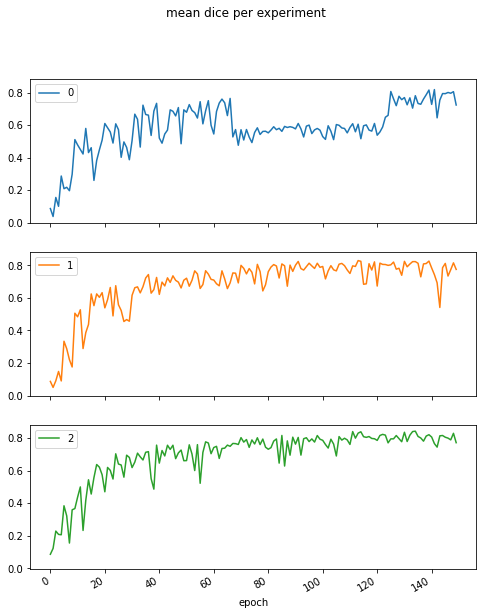

In [20]:
df.set_index(['experiment', 'epoch']).mean_dice.unstack('experiment').plot(figsize=(8,10), subplots=True, sharey=True, title='mean dice per experiment');

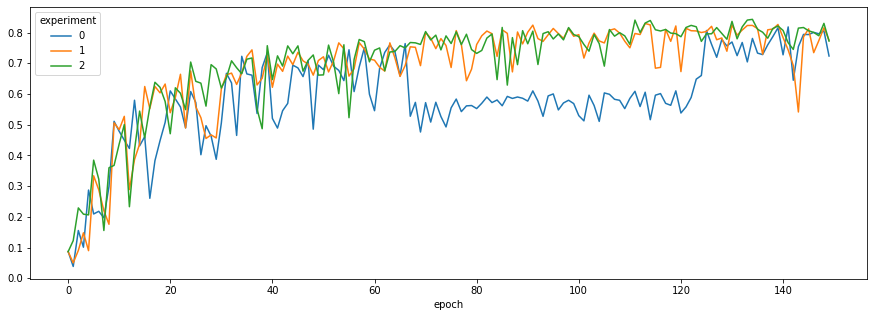

In [18]:
df.set_index(['experiment', 'epoch']).mean_dice.unstack('experiment').plot(figsize=(15,5));

In [8]:
df_best_epoch = df.sort_values('mean_dice', ascending=False).drop_duplicates('experiment', keep='first')
df_best_epoch.head()

,dice_background,dice_bladder,dice_bowel_bag,dice_hip,dice_rectum,epoch,mean_dice,precision_background,precision_bladder,precision_bowel_bag,...,recall_hip,recall_rectum,train_loss,val_loss,results_path,experiment,augmentation_brightness,augmentation_contrast,augmentation_rotate3d,nepochs
134,0.998519,0.870000,0.837037,0.884444,0.780370,134,0.842963,0.999630,0.897037,0.831481,...,0.968889,0.829630,0.463864,0.438908,/export/scratch3/bvdp/segmentation/OAR_segment...,2,1,1,3,150
413,0.999630,0.858519,0.805556,0.901111,0.752963,113,0.829537,0.997037,0.878519,0.852963,...,0.937037,0.893704,0.459718,0.450382,/export/scratch3/bvdp/segmentation/OAR_segment...,1,1,1,2,150
291,0.998889,0.861111,0.824444,0.822593,0.765185,141,0.818333,0.998889,0.849259,0.816667,...,0.737778,0.807778,0.453984,0.459295,/export/scratch3/bvdp/segmentation/OAR_segment...,0,1,1,1,150


In [26]:
import numpy as np
np.mean([0.83851852,0.87407407, 0.90592593, 0.78185185])
# np.mean([0.80851852, 0.8637037,  0.90333333, 0.75296296])

0.8500925925

In [21]:
df_best_epoch = df.sort_values('mean_dice', ascending=False).drop_duplicates('experiment', keep='first')
df_best_epoch[['experiment', 'epoch', 'augmentation_brightness', 'augmentation_contrast', 'augmentation_rotate3d', 'mean_dice', 'dice_bladder', 'dice_bowel_bag', 'dice_hip', 'dice_rectum']]

,experiment,epoch,augmentation_brightness,augmentation_contrast,augmentation_rotate3d,mean_dice,dice_bladder,dice_bowel_bag,dice_hip,dice_rectum
134,2,134,1,1,3,0.842963,0.870000,0.837037,0.884444,0.780370
413,1,113,1,1,2,0.829537,0.858519,0.805556,0.901111,0.752963
291,0,141,1,1,1,0.818333,0.861111,0.824444,0.822593,0.765185


In [247]:
# df_best_epoch.groupby(['loss_function', 'lr', 'accumulate_batches']).mean_dice.max().unstack('loss_function').plot.bar(figsize=(12,7))
# plt.legend(loc='lower right')
# plt.grid()

In [395]:
df_best_epoch.set_index('experiment')[['mean_dice', 'dice_bowel_bag', 'dice_bladder', 'dice_hip', 'dice_rectum', 'augmentation_brightness', 'augmentation_contrast', 'augmentation_rotate3d']] \
    .sort_values('mean_dice', ascending=False)

,mean_dice,dice_bowel_bag,dice_bladder,dice_hip,dice_rectum,augmentation_brightness,augmentation_contrast,augmentation_rotate3d
experiment,,,,,,,,
2,0.842963,0.837037,0.870000,0.884444,0.780370,1,1,3
1,0.829537,0.805556,0.858519,0.901111,0.752963,1,1,2
0,0.818333,0.824444,0.861111,0.822593,0.765185,1,1,1


In [288]:
df_best_epoch.set_index('experiment')[['mean_dice', 'dice_bowel_bag', 'dice_bladder', 'dice_hip', 'dice_rectum', 'accumulate_batches', 'lr', 'loss_function', 'class_weights']]#.to_csv('best_epoch_results_05-11-2020.csv')

KeyError: "['loss_function', 'class_weights', 'accumulate_batches', 'lr'] not in index"

In [185]:
# df_best_epoch

In [248]:
# df_best_epoch[['mean_dice', 'accumulate_batches', 'lr', 'loss_function', 'class_weights','gamma', 'experiment']]

In [135]:
# df_best_epoch[df_best_epoch.accumulate_batches == 16].mean_dice.describe()

In [136]:
# df_best_epoch[df_best_epoch.accumulate_batches == 8].mean_dice.describe()

In [137]:
# df_best_epoch[df_best_epoch.accumulate_batches == 1].mean_dice.describe()

In [37]:
# df_best_epoch.to_csv('results/best_epoch_results.csv', index=False)

In [249]:
df_best_epoch.groupby('accumulate_batches').apply(lambda x: x.mean_dice.describe())

mean_dice,count,mean,std,min,25%,50%,75%,max
accumulate_batches,,,,,,,,
1,16.0,0.643947,0.166706,0.350926,0.474560,0.690972,0.798194,0.820185
8,16.0,0.752789,0.039103,0.669815,0.731042,0.756944,0.776319,0.810556
16,16.0,0.716528,0.050819,0.622037,0.667569,0.719583,0.762176,0.790741


In [150]:
df_best_epoch.groupby('weight_decay').apply(lambda x: x.mean_dice.describe())

mean_dice,count,mean,std,min,25%,50%,75%,max
weight_decay,,,,,,,,
0.0001,24.0,0.559055,0.168094,0.245833,0.412477,0.603750,0.707477,0.800741
0.0010,24.0,0.386609,0.227836,0.000185,0.181088,0.468472,0.590208,0.691019
0.0100,24.0,0.124267,0.094460,0.000000,0.047431,0.118380,0.216898,0.303241


In [121]:
df_best_epoch.groupby('loss_function').apply(lambda x: x.mean_dice.describe())

mean_dice,count,mean,std,min,25%,50%,75%,max
loss_function,,,,,,,,
cross_entropy,6.0,0.708549,0.126984,0.473519,0.679722,0.757963,0.792523,0.804167
focal_loss,11.0,0.698047,0.086521,0.474907,0.665648,0.718426,0.746204,0.796944
soft_dice,6.0,0.749460,0.083183,0.590278,0.743171,0.777454,0.794097,0.820185


In [122]:
df_best_epoch.groupby('lr').apply(lambda x: x.mean_dice.describe())

mean_dice,count,mean,std,min,25%,50%,75%,max
lr,,,,,,,,
0.001,11.0,0.742315,0.060536,0.656944,0.697500,0.748056,0.797639,0.820185
0.010,12.0,0.688426,0.115715,0.473519,0.645833,0.727824,0.771713,0.800741


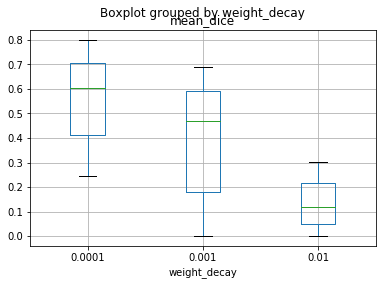

In [151]:
df_best_epoch.boxplot('mean_dice', 'weight_decay')

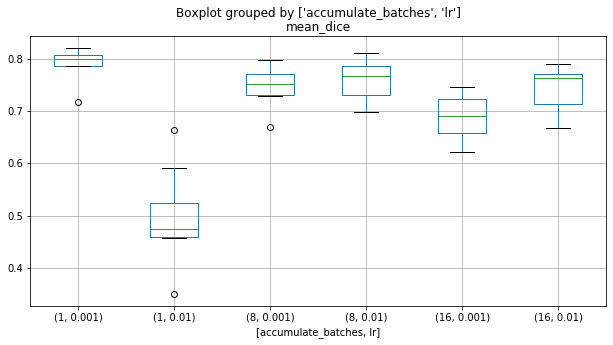

In [257]:
df_best_epoch.boxplot('mean_dice', ['accumulate_batches','lr'], figsize=(10,5))

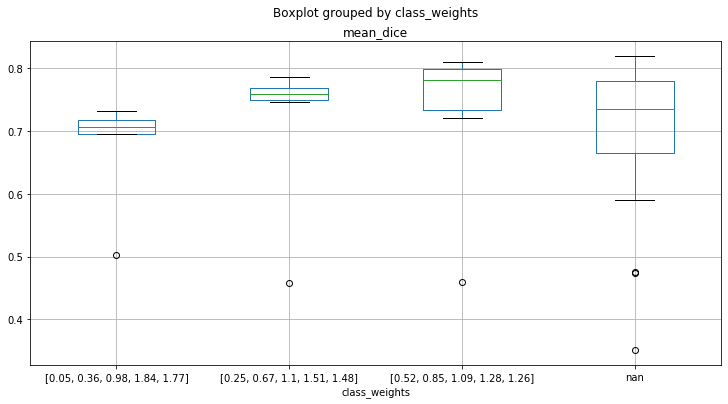

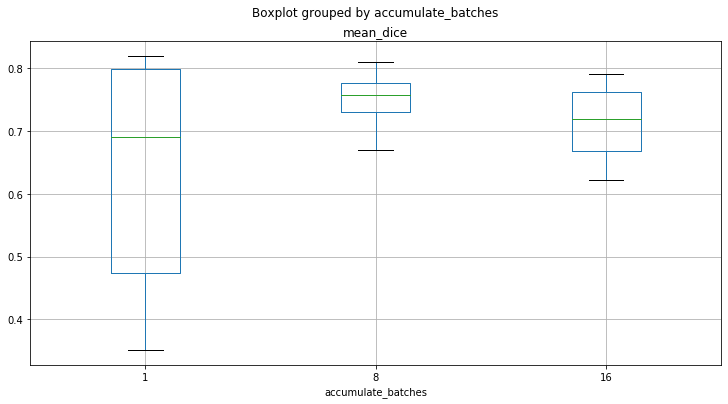

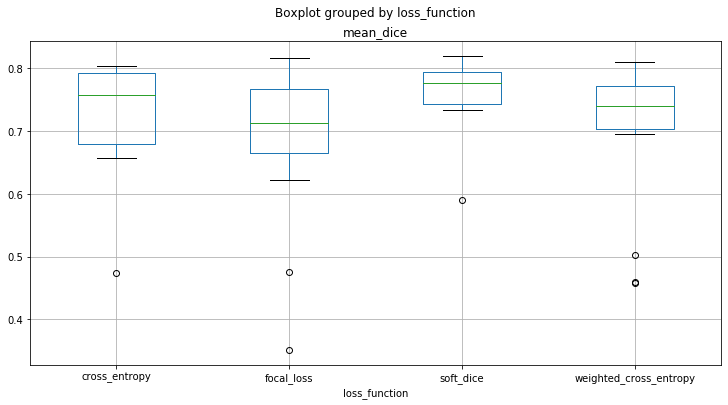

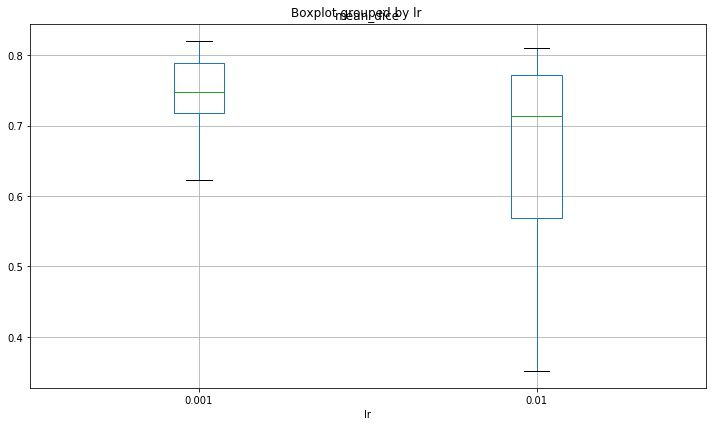

In [259]:
df_best_epoch.assign(
    class_weights = df_best_epoch.class_weights.astype(str)
).boxplot('mean_dice', 'class_weights', figsize=(12,6))
df_best_epoch.boxplot('mean_dice', 'accumulate_batches', figsize=(12,6))
df_best_epoch.boxplot('mean_dice', 'loss_function', figsize=(12,6))
# df_best_epoch.boxplot('mean_dice', 'weight_decay')
df_best_epoch.boxplot('mean_dice', 'lr', figsize=(10,6))
plt.tight_layout()

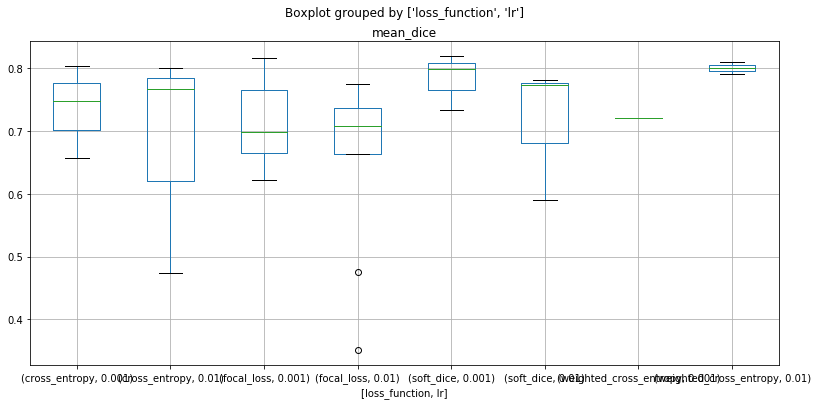

In [200]:
df_best_epoch.boxplot('mean_dice', ['loss_function', 'lr'], figsize=(13,6))

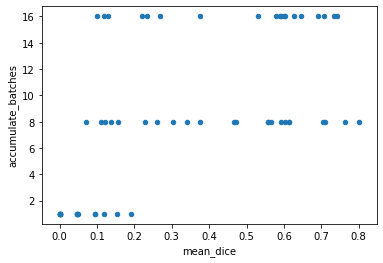

In [95]:
df_best_epoch.plot.scatter('mean_dice', 'accumulate_batches')

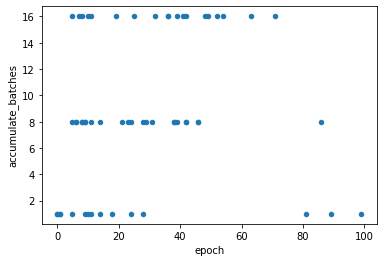

In [98]:
df_best_epoch.plot.scatter('epoch', 'accumulate_batches')

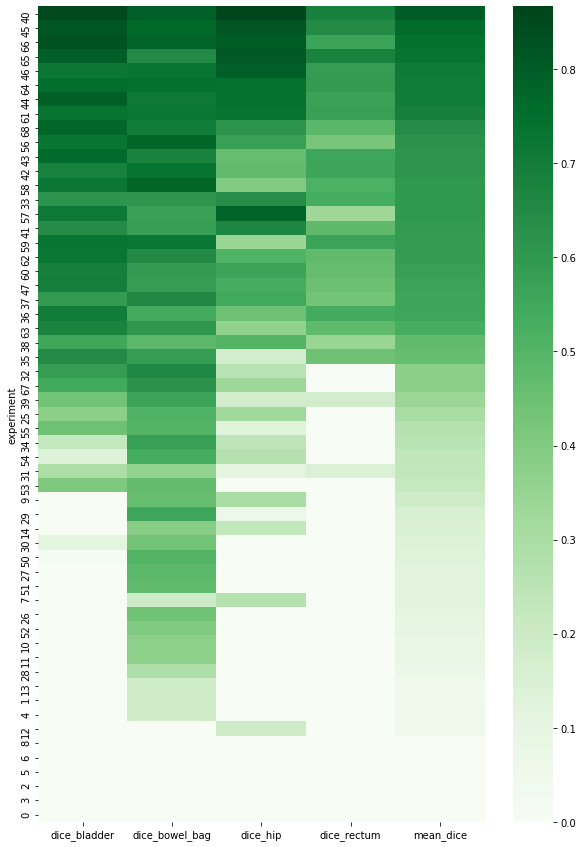

In [111]:
cols = [col for col in df_best_epoch.columns if "dice" in col and not "background" in col]

fig, ax = plt.subplots(figsize=(10,15))
sns.heatmap(df_best_epoch.set_index('experiment')[cols], cmap='Greens')

In [93]:
# fig, ax = plt.subplots(figsize=(15,15))
# df_best_epoch.boxplot('mean_dice', by='loss_function', ax=ax);

In [54]:
df.experiment.value_counts()

0     100
5     100
2     100
6     100
3     100
40     97
68     82
66     74
65     65
58     63
59     60
60     59
45     57
44     57
42     53
64     53
46     53
61     52
62     50
43     50
35     49
36     49
57     47
63     47
56     43
38     42
33     40
47     39
4      39
67     36
37     35
9      35
41     34
32     32
53     30
10     29
31     25
50     22
7      22
27     22
51     21
11     21
30     20
28     20
13     20
52     19
25     19
39     19
54     18
29     17
26     17
34     16
55     16
1      16
14     12
8      12
12     11
Name: experiment, dtype: int64

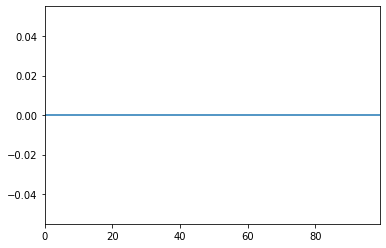

In [55]:
df[df.experiment == 0].mean_dice.plot()

# question monika

In [48]:
dataset_meta_path = '/export/scratch3/bvdp/segmentation/OAR_segmentation/data_preparation/meta/dataset_train_21-08-2020.csv'

In [49]:
meta_df = pd.read_csv(dataset_meta_path)

In [79]:
pixel_spacings = meta_df.PixelSpacing.str.extract(r'\[(?P<x>.*),(?P<y>.*)\]').astype(float)
pixel_spacings.x.describe()

count    1170.000000
mean        1.117386
std         0.119228
min         0.488281
25%         0.976562
50%         1.171875
75%         1.171875
max         1.269531
Name: x, dtype: float64

In [80]:
pixel_spacings.x.value_counts()

1.171875    533
0.976562    407
1.269531    216
1.074219      3
0.683594      2
0.781250      2
0.943359      1
0.715397      1
0.615234      1
0.585938      1
0.800781      1
0.751953      1
0.488281      1
Name: x, dtype: int64

In [85]:
slice_thicknesses = meta_df.SliceThickness.astype(float)
slice_thicknesses.describe()

count    1170.000000
mean        2.343120
std         0.513989
min         1.200000
25%         2.500000
50%         2.500000
75%         2.500000
max         3.000000
Name: SliceThickness, dtype: float64

In [86]:
slice_thicknesses.value_counts()

2.50    849
1.25    195
3.00    124
1.20      1
2.00      1
Name: SliceThickness, dtype: int64

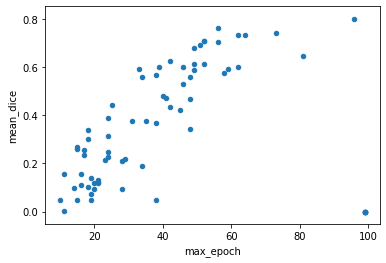

In [101]:
bla = df.groupby('experiment').epoch.max().rename('max_epoch').to_frame().reset_index()
df_best_epoch.merge(bla, on='experiment')[['experiment', 'mean_dice', 'max_epoch']].plot.scatter('max_epoch', 'mean_dice')

experiment
0     99
1     15
2     99
3     99
4     38
5     99
6     99
7     21
8     11
9     34
10    28
11    20
12    10
13    19
14    11
15    28
16    24
17    45
18    48
19    38
20    24
21    24
22    40
23    42
24    14
25    18
26    16
27    21
28    19
29    16
      ..
42    52
43    49
44    56
45    56
46    52
47    38
48    23
49    17
50    21
51    20
52    18
53    29
54    17
55    15
56    42
57    46
58    62
59    59
60    58
61    51
62    49
63    46
64    52
65    64
66    73
67    35
68    81
69    49
70    62
71    25
Name: epoch, Length: 72, dtype: int64